In [2]:
%load_ext autoreload
%autoreload 2

import logging, warnings
import itertools
from sklearn.model_selection import KFold
import numpy as np
import keras

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17800721421942902567
]


------
## Performace Evaluation Functions

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

-----
## Load Data

In [3]:
loader = HCDRLoader()

# load index values from main table
app_ix = loader.applications_train_index()
sequence_length = 25

2018-07-10 01:34:18,594 - DEBUG - Initializing data loader
2018-07-10 01:34:18,595 - DEBUG - Reading application_train.csv...
2018-07-10 01:34:23,723 - DEBUG - Finished reading application_train.csv
2018-07-10 01:34:23,724 - DEBUG - Loading bureau data...
2018-07-10 01:34:30,227 - DEBUG - Loading previous application data...
2018-07-10 01:34:52,182 - DEBUG - Done


In [4]:
# fit model using k-fold verification
kf = KFold(n_splits=4, shuffle=True)
for fold_indexes in kf.split(app_ix):
    pass #print(fold_indexes[0].shape, fold_indexes[1].shape)
    
data_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1])
cc_data_train = loader.read_credit_card_balance(app_ix.values[fold_indexes[0]], t_max=sequence_length)
cc_data_val = loader.read_credit_card_balance(app_ix.values[fold_indexes[1]], t_max=sequence_length)

2018-07-10 01:34:52,251 - DEBUG - Preparing applications data...
2018-07-10 01:34:54,578 - DEBUG - Performing soft impute on current home info...
2018-07-10 01:35:00,457 - DEBUG - Running PCA on current home info...
2018-07-10 01:35:02,443 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-07-10 01:35:03,903 - DEBUG - Preparing applications data...
2018-07-10 01:35:04,673 - DEBUG - Performing soft impute on current home info...
2018-07-10 01:35:06,151 - DEBUG - Running PCA on current home info...
2018-07-10 01:35:06,281 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-07-10 01:35:06,301 - DEBUG - Collating training data...
2018-07-10 01:35:10,021 - DEBUG - Collating validation data...
2018-07-10 01:35:11,680 - DEBUG - Scaling train and validation data...
2018-07-10 01:35:13,249 - DEBUG - Done
2018-07-10 01:35:13,254 - DEBUG - Reading credit card balance file...
2018-07-10 01:35:25,859 - DEBUG - Preparing credit card balance 

In [5]:
data_train.shape, target_train.shape, data_val.shape, target_val.shape, cc_data_train.shape, cc_data_val.shape

((230634, 225), (230634,), (76877, 225), (76877,), (230634, 650), (76877, 650))

In [6]:
sequence_features = np.int(cc_data_train.shape[1] / sequence_length)
meta_features = np.int(data_train.shape[1])

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
data_train_os, target_train_os = ros.fit_sample(data_train, target_train)

In [8]:
np.unique(target_train_os, return_counts=True)

(array([0, 1]), array([211947, 211947]))

In [9]:
ros_index = RandomOverSampler()
data_train_os_index, target_train_os = ros_index.fit_sample(np.arange(data_train.shape[0]).reshape(-1, 1), target_train)

In [10]:
data_train_os = data_train[data_train_os_index.squeeze()]
cc_data_train_os = cc_data_train[data_train_os_index.squeeze()]

In [11]:
np.unique(target_train_os, return_counts=True)

(array([0, 1]), array([211947, 211947]))

In [3]:
import ast

with open('grid_search_params.txt','r') as f:
    dict_from_file = ast.literal_eval(f.read())

In [4]:
dict_from_file

{'comb_dense_layers': [1],
 'comb_dense_width': [64],
 'comb_dropout': [0.2],
 'comb_l2_reg': [1e-05],
 'lstm_l2_reg': [1e-06, 1e-07, 1e-08],
 'lstm_units': [16, 32, 64],
 'meta_dense_layers': [1],
 'meta_dense_width': [64],
 'meta_dropout': [0.2],
 'meta_l2_reg': [1e-05],
 'sequence_dense_layers': [0],
 'sequence_dense_width': [8],
 'sequence_l2_reg': [0]}

-----

## Linear Deep Neural Network

In [7]:
from models import LinearNN

linear_nn = LinearNN(data_train_os.shape[1], l2_reg=1e-3)
linear_nn.fit(data_train_os, target_train_os, data_val, target_val, num_epochs=5)

Using TensorFlow backend.


Train on 423952 samples, validate on 76877 samples
Epoch 1/5
423952/423952 [==============================] - 26s 62us/step - loss: 0.6169 - acc: 0.6845 - val_loss: 0.6704 - val_acc: 0.6429
Epoch 2/5
423952/423952 [==============================] - 25s 59us/step - loss: 0.5980 - acc: 0.6908 - val_loss: 0.6702 - val_acc: 0.6482
Epoch 3/5
423952/423952 [==============================] - 25s 59us/step - loss: 0.5955 - acc: 0.6940 - val_loss: 0.6264 - val_acc: 0.6759
Epoch 4/5
423952/423952 [==============================] - 26s 61us/step - loss: 0.5942 - acc: 0.6945 - val_loss: 0.6788 - val_acc: 0.6420
Epoch 5/5
423952/423952 [==============================] - 28s 66us/step - loss: 0.5935 - acc: 0.6955 - val_loss: 0.6049 - val_acc: 0.6907


Normalized confusion matrix
[[ 0.69299958  0.30700042]
 [ 0.33517107  0.66482893]]


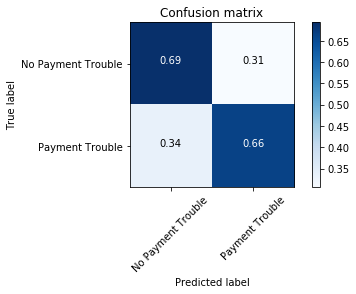

In [9]:
from sklearn.metrics import confusion_matrix

predict_val = linear_nn.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)


In [12]:
np.unique(predict_val, return_counts=True), np.unique(predict_val, return_counts=True)

((array([ 0.,  1.], dtype=float32), array([51821, 25056])),
 (array([  4.58533222e-13,   5.61111380e-10,   4.66813299e-09, ...,
           9.99993324e-01,   9.99995232e-01,   9.99995947e-01], dtype=float32),
  array([1, 1, 1, ..., 1, 1, 1])))

-----
## Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Normalized confusion matrix
[[ 0.99684627  0.00315373]
 [ 0.98135236  0.01864764]]


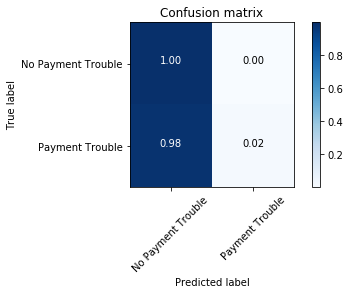

In [16]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

-----
## AdaBoost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=None)

Normalized confusion matrix
[[ 0.68578702  0.31421298]
 [ 0.36873683  0.63126317]]


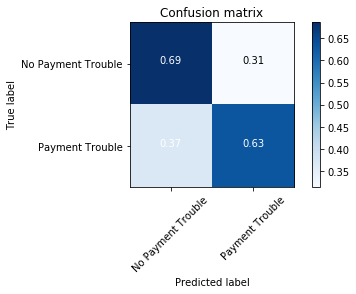

In [18]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

-----
## Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=10)
clf.fit(data_train_os, target_train_os)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Normalized confusion matrix
[[ 0.65047377  0.34952623]
 [ 0.32998216  0.67001784]]


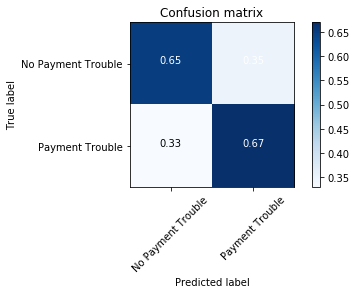

In [20]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

-----
## K-Nearest Neighbors Classifier
### Don't run this one

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(data_train_os, target_train_os)

In [ ]:
from sklearn.metrics import confusion_matrix

predict_val = clf.predict(data_val)
cm = confusion_matrix(target_val, predict_val.round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

-----
## LSTM with Metadata

In [14]:
from models import LSTMWithMetadata

lstm_nn = LSTMWithMetadata(sequence_length, sequence_features, meta_features)
lstm_nn.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         (None, 650)          0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 25, 26)       0           lstm_input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 8)            1120        reshaped_input[0][0]             
__________________________________________________________________________________________________
meta_input (InputLayer)         (None, 225)          0                                            
__________________________________________________________________________________________________
seq_dense_

In [15]:
history = lstm_nn.fit(cc_data_train_os, data_train_os, target_train_os,
                      cc_data_val, data_val, target_val,
                      num_epochs=2)

Train on 423956 samples, validate on 76877 samples
Epoch 1/2
423956/423956 [==============================] - 333s 785us/step - loss: 1.7612 - main_output_loss: 1.4499 - lstm_output_loss: 1.5567 - main_output_acc: 0.6667 - lstm_output_acc: 0.5121 - val_loss: 2.1830 - val_main_output_loss: 1.8150 - val_lstm_output_loss: 1.8400 - val_main_output_acc: 0.6442 - val_lstm_output_acc: 0.8266
Epoch 2/2
423956/423956 [==============================] - 332s 782us/step - loss: 1.6315 - main_output_loss: 1.3472 - lstm_output_loss: 1.4215 - main_output_acc: 0.6826 - lstm_output_acc: 0.5168 - val_loss: 1.3203 - val_main_output_loss: 1.0449 - val_lstm_output_loss: 1.3770 - val_main_output_acc: 0.6919 - val_lstm_output_acc: 0.8407


In [16]:
predict_val = lstm_nn.predict(cc_data_val, data_val)

2018-07-09 10:09:52,107 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('c:\\users\\meeting\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
2018-07-09 10:09:52,138 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('c:\\users\\meeting\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


Normalized confusion matrix
[[0.69656899 0.30343101]
 [0.36148484 0.63851516]]


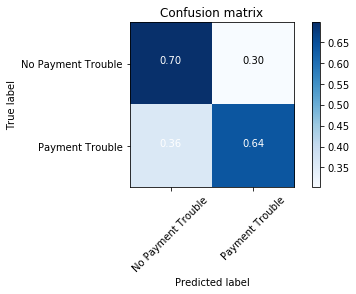

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_val, predict_val[0].round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

In [20]:
cm

array([[49253, 21455],
       [ 2230,  3939]], dtype=int64)

----
## Raw LSTM Model

In [12]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Reshape, concatenate
from keras.regularizers import l2

num_dense_layers=1
meta_l2_reg = 1e-5
comb_l2_reg = 1e-5

lstm_input = Input(shape=(sequence_length*sequence_features,), name='lstm_input')
reshaped_input = Reshape((sequence_length, sequence_features), name='reshaped_input')(lstm_input)
lstm = LSTM(8, activation='relu', go_backwards=False, name='lstm')(reshaped_input)
lstm_output = Dense(1, activation='sigmoid', name='lstm_output')(lstm)
meta_input = Input(shape=(meta_features,), name='meta_input')
meta_dense = Dense(64, activation='relu', kernel_regularizer=l2(meta_l2_reg), name='meta_dense')(meta_input)
x = concatenate([lstm, meta_dense], name='concatenate')
for i in range(num_dense_layers):
    x = Dense(32, activation='relu', kernel_regularizer=l2(comb_l2_reg), name='combined_dense_{}'.format(i))(x)
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

lstm_model = Model(inputs=[lstm_input, meta_input], outputs=[main_output, lstm_output])

lstm_model.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   loss_weights=[1., 0.2],
                   metrics=['accuracy'])


In [13]:
lstm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         (None, 650)          0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 25, 26)       0           lstm_input[0][0]                 
__________________________________________________________________________________________________
meta_input (InputLayer)         (None, 225)          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 8)            1120        reshaped_input[0][0]             
__________________________________________________________________________________________________
meta_dense

In [14]:
ts_data_train = cc_data_train_os
meta_data_train = data_train_os
ts_data_val = cc_data_val
meta_data_val = data_val
num_epochs=3
batch_size=32

lstm_model.fit([ts_data_train, meta_data_train], [target_train_os, target_train_os],
                validation_data=([ts_data_val, meta_data_val], [target_val, target_val]),
                epochs=num_epochs, batch_size=batch_size)

Train on 282722 samples, validate on 153755 samples
Epoch 1/3
282722/282722 [==============================] - 326s 1ms/step - loss: 0.7599 - main_output_loss: 0.6112 - lstm_output_loss: 0.7331 - main_output_acc: 0.6949 - lstm_output_acc: 0.5296 - val_loss: 0.7088 - val_main_output_loss: 0.5644 - val_lstm_output_loss: 0.7071 - val_main_output_acc: 0.7086 - val_lstm_output_acc: 0.8278
Epoch 2/3
282722/282722 [==============================] - 406s 1ms/step - loss: 0.7144 - main_output_loss: 0.5691 - lstm_output_loss: 0.7068 - main_output_acc: 0.7205 - lstm_output_acc: 0.5331 - val_loss: 0.8188 - val_main_output_loss: 0.6666 - val_lstm_output_loss: 0.7357 - val_main_output_acc: 0.6588 - val_lstm_output_acc: 0.8303
Epoch 3/3
282722/282722 [==============================] - 385s 1ms/step - loss: 0.7282 - main_output_loss: 0.5746 - lstm_output_loss: 0.7370 - main_output_acc: 0.7379 - lstm_output_acc: 0.5299 - val_loss: 0.7061 - val_main_output_loss: 0.5432 - val_lstm_output_loss: 0.7784 - v

In [15]:
predict_val = lstm_model.predict([ts_data_val, meta_data_val])

Normalized confusion matrix
[[ 0.78530338  0.21469662]
 [ 0.4928399   0.5071601 ]]


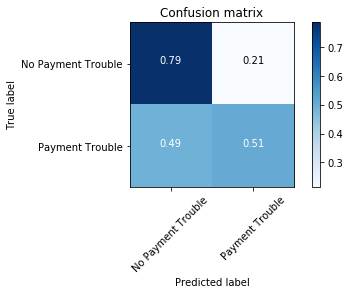

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_val, predict_val[0].round())
plot_confusion_matrix(cm, ['No Payment Trouble', 'Payment Trouble'], normalize=True)

-----
## Grid search on LSTM parameters

In [12]:
from imblearn.over_sampling import RandomOverSampler
import itertools
from models import LSTMWithMetadata
import pandas as pd

loader = HCDRLoader()

# load index values from main table
app_ix = loader.applications_train_index()
sequence_length = 25

hyperparameters = {
    'sequence_dense_layers': [0],
    'sequence_dense_width': [4],
    'sequence_l2_reg': [0],
    'meta_dense_layers': [0, 1],
    'meta_dense_width': [32],
    'comb_dense_layers': [0],
    'lstm_units': [4]
}

keys, values = zip(*hyperparameters.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
exp_df = pd.DataFrame(experiments)

cm = np.zeros((len(experiments), 2, 2), dtype=int)

2018-07-10 11:40:14,617 - DEBUG - Initializing data loader
2018-07-10 11:40:14,617 - DEBUG - Reading application_train.csv...
2018-07-10 11:40:19,645 - DEBUG - Finished reading application_train.csv
2018-07-10 11:40:19,645 - DEBUG - Loading bureau data...
2018-07-10 11:40:27,475 - DEBUG - Loading previous application data...
2018-07-10 11:40:55,648 - DEBUG - Done


In [ ]:
# fit model using k-fold verification
kf = KFold(n_splits=4, shuffle=True)
for j, fold_indexes in enumerate(kf.split(app_ix)):
    data_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1])
    cc_data_train = loader.read_credit_card_balance(app_ix.values[fold_indexes[0]], t_max=sequence_length)
    cc_data_val = loader.read_credit_card_balance(app_ix.values[fold_indexes[1]], t_max=sequence_length)

    sequence_features = np.int(cc_data_train.shape[1] / sequence_length)
    meta_features = np.int(data_train.shape[1])

    ros = RandomOverSampler()
    data_train_os_index, target_train_os = ros.fit_sample(np.arange(data_train.shape[0]).reshape(-1, 1), target_train)
    data_train_os = data_train[data_train_os_index.squeeze()]
    cc_data_train_os = cc_data_train[data_train_os_index.squeeze()]
    
    for i, experiment in enumerate(experiments):
        lstm_nn = LSTMWithMetadata(sequence_length, sequence_features, meta_features,
                                   **experiment)
        history = lstm_nn.fit(cc_data_train_os, data_train_os, target_train_os,
                              cc_data_val, data_val, target_val,
                              num_epochs=2)
        predict_val = lstm_nn.predict(cc_data_val, data_val)
        cm_fold = confusion_matrix(target_val, predict_val[0].round())
        cm[i, :, :] = cm[i, :, :] + cm_fold
        plot_confusion_matrix(cm_fold, ['No Payment Trouble', 'Payment Trouble'], normalize=True, title='Fold {}'.format(j))
        plt.show()

2018-07-10 11:12:36,898 - DEBUG - Initializing data loader
2018-07-10 11:12:36,898 - DEBUG - Reading application_train.csv...
2018-07-10 11:12:41,478 - DEBUG - Finished reading application_train.csv
2018-07-10 11:12:41,478 - DEBUG - Loading bureau data...
2018-07-10 11:12:48,738 - DEBUG - Loading previous application data...
2018-07-10 11:13:17,187 - DEBUG - Done
2018-07-10 11:13:17,218 - DEBUG - Preparing applications data...
2018-07-10 11:13:21,111 - DEBUG - Performing soft impute on current home info...
2018-07-10 11:13:29,239 - DEBUG - Running PCA on current home info...
2018-07-10 11:13:31,663 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-07-10 11:13:33,504 - DEBUG - Preparing applications data...
2018-07-10 11:13:34,887 - DEBUG - Performing soft impute on current home info...
2018-07-10 11:13:38,425 - DEBUG - Running PCA on current home info...
2018-07-10 11:13:38,697 - DEBUG - Performing linear regression on goods price and annuity amount...
20

Train on 424146 samples, validate on 76878 samples
Epoch 1/2
293152/424146 [===================>..........] - ETA: 1:38 - loss: 0.8572 - main_output_loss: 0.6989 - lstm_output_loss: 0.7915 - main_output_acc: 0.6732 - lstm_output_acc: 0.5184

In [5]:
lstm_nn.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_input (InputLayer)         (None, 650)          0                                            
__________________________________________________________________________________________________
reshaped_input (Reshape)        (None, 25, 26)       0           lstm_input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 8)            1120        reshaped_input[0][0]             
__________________________________________________________________________________________________
meta_input (InputLayer)         (None, 225)          0                                            
__________________________________________________________________________________________________
concatenat

In [2]:
a = (15, 15)
a

(15, 15)

In [4]:
tuple(list(a))

(15, 15)

-----
## Model Averaging

In [1]:
%load_ext autoreload
%autoreload 2

import logging, warnings
import itertools
from prepare_data import HCDRDataLoader
from sklearn.model_selection import KFold
import numpy as np
import keras
from imblearn.over_sampling import RandomOverSampler
from models import LinearNN, GBC, ABC, MultiLSTMWithMetadata
from sklearn.linear_model import LogisticRegression

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

c:\users\meeting\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

loader_args = {
        'cc_tmax': 60,
        'bureau_tmax': 60,
        'pos_tmax': 60
    }

loader = HCDRDataLoader(**loader_args)
app_ix = loader.get_index()

2018-08-16 09:08:35,280 - DEBUG - Initializing data loader
2018-08-16 09:08:42,394 - DEBUG - Performing soft impute on current home info...
2018-08-16 09:08:45,245 - DEBUG - Running PCA on current home info...


In [3]:
app_ix

Int64Index([100002, 100003, 100004, 100006, 100007, 100008, 100009, 100010,
            100011, 100012,
            ...
            456245, 456246, 456247, 456248, 456249, 456251, 456252, 456253,
            456254, 456255],
           dtype='int64', name='SK_ID_CURR', length=307511)

In [4]:
# fit model using k-fold verification
kf = KFold(n_splits=4, shuffle=True)
for fold_indexes in kf.split(app_ix):
    pass

In [5]:
data_train_ts, target_train_ts, data_val_ts, target_val_ts = loader.load_train_val(fold_indexes[0], fold_indexes[1])
input_shape = loader.get_input_shape()

2018-08-16 09:09:25,318 - DEBUG - Preparing applications data...
2018-08-16 09:09:27,490 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-08-16 09:09:35,567 - DEBUG - Reading credit card balance file...
2018-08-16 09:09:51,435 - DEBUG - Preparing credit card balance data...
2018-08-16 09:10:46,925 - DEBUG - Sparsifying...
2018-08-16 09:11:05,814 - DEBUG - Done
2018-08-16 09:11:27,566 - DEBUG - Preparing credit bureau balance data...
2018-08-16 09:11:55,948 - DEBUG - Sparsifying...
2018-08-16 09:12:02,690 - DEBUG - Done
2018-08-16 09:13:26,007 - DEBUG - Preparing POS cash data...
2018-08-16 09:14:31,329 - DEBUG - Done
2018-08-16 09:14:38,695 - DEBUG - [(225,), (60, 26), (60, 8), (60, 13)]
2018-08-16 09:14:38,726 - DEBUG - Preparing applications data...
2018-08-16 09:14:40,679 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-08-16 09:14:43,773 - DEBUG - Reading credit card balance file...
2018-08-16 09:14:59,587 - DEBUG - Pr

In [6]:
""" 
# load training and validation summary data
loader_args = {
    'load_time_series': False
}
data_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1], loader_args)
"""

" \n# load training and validation summary data\nloader_args = {\n    'load_time_series': False\n}\ndata_train, target_train, data_val, target_val = loader.load_train_val(fold_indexes[0], fold_indexes[1], loader_args)\n"

In [7]:
# oversample troubled loans to make up for imbalance
ros = RandomOverSampler()
os_index, target_train_os = ros.fit_sample(np.arange(data_train_ts[0].shape[0]).reshape(-1, 1), target_train_ts)

#data_train_os = data_train[os_index.squeeze()]

In [8]:
data_train_ts_os = [data_train_part[os_index.squeeze()] for data_train_part in data_train_ts]
target_train_ts_os = target_train_ts.values[os_index.squeeze()]

In [9]:
num_models = 4
train_samples = target_train_ts.shape[0]
val_samples = target_val_ts.shape[0]
train_results = np.empty((train_samples, num_models))
val_results = np.empty((val_samples, num_models))

In [11]:
# train on linear neural network
linear_nn = LinearNN(data_train_ts_os[0].shape[1], epochs=25)
linear_nn.fit(data_train_ts_os[0], target_train_ts_os, validation_data=(data_val_ts[0], target_val_ts))
# TODO: use predict on out of sample data and store results for each model

Train on 423924 samples, validate on 76877 samples
Epoch 1/25
 - 5s - loss: 0.5872 - acc: 0.6917 - val_loss: 0.5806 - val_acc: 0.6978
Epoch 2/25
 - 4s - loss: 0.5586 - acc: 0.7141 - val_loss: 0.5584 - val_acc: 0.7120
Epoch 3/25
 - 4s - loss: 0.5437 - acc: 0.7260 - val_loss: 0.5708 - val_acc: 0.7044
Epoch 4/25
 - 4s - loss: 0.5323 - acc: 0.7335 - val_loss: 0.5511 - val_acc: 0.7279
Epoch 5/25
 - 4s - loss: 0.5232 - acc: 0.7395 - val_loss: 0.5839 - val_acc: 0.6992
Epoch 6/25
 - 5s - loss: 0.5169 - acc: 0.7451 - val_loss: 0.5718 - val_acc: 0.7116
Epoch 7/25
 - 4s - loss: 0.5111 - acc: 0.7486 - val_loss: 0.5404 - val_acc: 0.7317
Epoch 8/25
 - 4s - loss: 0.5063 - acc: 0.7518 - val_loss: 0.5763 - val_acc: 0.7120
Epoch 9/25
 - 5s - loss: 0.5023 - acc: 0.7545 - val_loss: 0.5743 - val_acc: 0.7124
Epoch 10/25
 - 4s - loss: 0.4993 - acc: 0.7570 - val_loss: 0.5581 - val_acc: 0.7244
Epoch 11/25
 - 4s - loss: 0.4966 - acc: 0.7582 - val_loss: 0.5766 - val_acc: 0.7169
Epoch 12/25
 - 4s - loss: 0.4938 -

In [12]:
train_results[:, 0] = linear_nn.predict(data_train_ts[0]).squeeze()
val_results[:, 0] = linear_nn.predict(data_val_ts[0]).squeeze()

In [13]:
# gradient boosting classifier
gbc = GBC()
gbc.fit(data_train_ts_os[0], target_train_os)

In [14]:
train_results[:, 1] = gbc.predict(data_train_ts[0]).squeeze()
val_results[:, 1] = gbc.predict(data_val_ts[0]).squeeze()

In [15]:
# adaboost classifier
abc = ABC()
abc.fit(data_train_ts_os[0], target_train_os)

In [16]:
train_results[:, 2] = abc.predict(data_train_ts[0]).squeeze()
val_results[:, 2] = abc.predict(data_val_ts[0]).squeeze()

In [17]:
model_args = {
        'epochs': 15,
        'batch_size': 512,
        'lstm_gpu': False,
        'sequence_dense_layers': 0,
        'sequence_dense_width': 8,
        'sequence_l2_reg': 0,
        'meta_dense_layers': 1,
        'meta_dense_width': 64,
        'meta_l2_reg': 1e-5,
        'meta_dropout': 0.2,
        'comb_dense_layers': 3,
        'comb_dense_width': 64,
        'comb_l2_reg': 1e-6,
        'comb_dropout': 0.2,
        'lstm_units': 8,
        'lstm_l2_reg': 1e-7
    }

lstm_nn = MultiLSTMWithMetadata(input_shape, **model_args)

In [18]:
lstm_nn.fit(data_train_ts_os, target_train_ts_os, validation_data=(data_val_ts, target_val_ts))

Train on 423924 samples, validate on 76877 samples
Epoch 1/15
 - 158s - loss: 1.0235 - main_output_loss: 0.6080 - lstm_output_0_loss: 0.6888 - lstm_output_1_loss: 0.6915 - lstm_output_2_loss: 0.6915 - main_output_acc: 0.6739 - lstm_output_0_acc: 0.5317 - lstm_output_1_acc: 0.5151 - lstm_output_2_acc: 0.5167 - val_loss: 0.9935 - val_main_output_loss: 0.5756 - val_lstm_output_0_loss: 0.6888 - val_lstm_output_1_loss: 0.7005 - val_lstm_output_2_loss: 0.6945 - val_main_output_acc: 0.6883 - val_lstm_output_0_acc: 0.8306 - val_lstm_output_1_acc: 0.2112 - val_lstm_output_2_acc: 0.8391
Epoch 2/15
 - 142s - loss: 0.9953 - main_output_loss: 0.5803 - lstm_output_0_loss: 0.6876 - lstm_output_1_loss: 0.6908 - lstm_output_2_loss: 0.6904 - main_output_acc: 0.6996 - lstm_output_0_acc: 0.5344 - lstm_output_1_acc: 0.5176 - lstm_output_2_acc: 0.5198 - val_loss: 0.9950 - val_main_output_loss: 0.5831 - val_lstm_output_0_loss: 0.6836 - val_lstm_output_1_loss: 0.6853 - val_lstm_output_2_loss: 0.6840 - val_mai

In [19]:
train_results[:, 3] = lstm_nn.predict(data_train_ts).squeeze()
val_results[:, 3] = lstm_nn.predict(data_val_ts).squeeze()

In [20]:
train_results.shape, target_train_ts.shape

((230634, 4), (230634,))

In [21]:
train_results[os_index.squeeze()], target_train_ts.values[os_index.squeeze()]

(array([[0.81751651, 1.        , 1.        , 0.8075552 ],
        [0.02682295, 0.        , 1.        , 0.06272607],
        [0.45872301, 1.        , 1.        , 0.40795016],
        ...,
        [0.92979306, 1.        , 1.        , 0.85843879],
        [0.82329023, 1.        , 1.        , 0.76993155],
        [0.67572904, 0.        , 1.        , 0.72348005]]),
 array([1, 0, 0, ..., 1, 1, 1], dtype=int64))

In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', C=0.01)
lr.fit(train_results, target_train_ts.values)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [36]:
lr.score(train_results, target_train_ts)

0.7822654075288119

In [37]:
lr.score(val_results, target_val_ts)

0.7390767069474615

In [25]:
import pandas as pd
results = pd.DataFrame(np.concatenate([val_results, target_val_ts.values.reshape(-1, 1)], axis=1))
results.to_csv('data/results.csv')

**Test data**

In [38]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

loader_args = {
    'cc_tmax': 60,
    'bureau_tmax': 60,
    'pos_tmax': 60
}

loader = HCDRDataLoader(**loader_args)

2018-08-16 11:55:49,876 - DEBUG - Initializing data loader
2018-08-16 11:55:57,272 - DEBUG - Performing soft impute on current home info...
2018-08-16 11:56:00,048 - DEBUG - Running PCA on current home info...


In [39]:
# load training and test data
data_train, target_train = loader.load_train_data()

2018-08-16 11:56:43,558 - DEBUG - Preparing applications data...
2018-08-16 11:56:46,889 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-08-16 11:56:58,096 - DEBUG - Reading credit card balance file...
2018-08-16 11:57:14,905 - DEBUG - Preparing credit card balance data...
2018-08-16 11:58:46,376 - DEBUG - Sparsifying...
2018-08-16 11:59:12,741 - DEBUG - Done
2018-08-16 11:59:35,424 - DEBUG - Preparing credit bureau balance data...
2018-08-16 12:00:14,767 - DEBUG - Sparsifying...
2018-08-16 12:00:22,377 - DEBUG - Done
2018-08-16 12:01:56,283 - DEBUG - Preparing POS cash data...
2018-08-16 12:03:21,036 - DEBUG - Done
2018-08-16 12:03:30,125 - DEBUG - [(225,), (60, 26), (60, 8), (60, 13)]


In [40]:
data_val = loader.load_test_data()

2018-08-16 12:03:30,719 - DEBUG - Preparing applications data...
2018-08-16 12:03:31,282 - DEBUG - Performing linear regression on goods price and annuity amount...
2018-08-16 12:03:33,688 - DEBUG - Reading credit card balance file...
2018-08-16 12:03:50,033 - DEBUG - Preparing credit card balance data...
2018-08-16 12:03:59,332 - DEBUG - Sparsifying...
2018-08-16 12:04:02,513 - DEBUG - Done
2018-08-16 12:04:24,725 - DEBUG - Preparing credit bureau balance data...
2018-08-16 12:04:33,680 - DEBUG - Sparsifying...
2018-08-16 12:04:34,852 - DEBUG - Done
2018-08-16 12:05:56,090 - DEBUG - Preparing POS cash data...
2018-08-16 12:06:06,477 - DEBUG - Done
2018-08-16 12:06:07,603 - DEBUG - [(225,), (60, 26), (60, 8), (60, 13)]


In [41]:
# oversample troubled loans to make up for imbalance
ros = RandomOverSampler()
os_index, target_train_os = ros.fit_sample(np.arange(data_train[0].shape[0]).reshape(-1, 1), target_train)
data_train_os = [data_train_part[os_index.squeeze()] for data_train_part in data_train]

In [42]:
# use predict on out of sample data and store results for each model
num_models = 4
train_samples = data_train[0].shape[0]
test_samples = data_val[0].shape[0]
train_results = np.empty((train_samples, num_models))
val_results = np.empty((test_samples, num_models))

In [43]:
# train on linear neural network
linear_nn = LinearNN(data_train_os[0].shape[1], epochs=25)
linear_nn.fit(data_train_os[0], target_train_os)

train_results[:, 0] = linear_nn.predict(data_train[0]).squeeze()
val_results[:, 0] = linear_nn.predict(data_val[0]).squeeze()

Epoch 1/25
 - 6s - loss: 0.5876 - acc: 0.6907
Epoch 2/25
 - 4s - loss: 0.5629 - acc: 0.7105
Epoch 3/25
 - 4s - loss: 0.5498 - acc: 0.7202
Epoch 4/25
 - 4s - loss: 0.5414 - acc: 0.7270
Epoch 5/25
 - 4s - loss: 0.5344 - acc: 0.7324
Epoch 6/25
 - 4s - loss: 0.5291 - acc: 0.7362
Epoch 7/25
 - 4s - loss: 0.5249 - acc: 0.7395
Epoch 8/25
 - 4s - loss: 0.5214 - acc: 0.7419
Epoch 9/25
 - 4s - loss: 0.5181 - acc: 0.7445
Epoch 10/25
 - 4s - loss: 0.5153 - acc: 0.7461
Epoch 11/25
 - 4s - loss: 0.5134 - acc: 0.7475
Epoch 12/25
 - 4s - loss: 0.5107 - acc: 0.7498
Epoch 13/25
 - 4s - loss: 0.5092 - acc: 0.7507
Epoch 14/25
 - 4s - loss: 0.5076 - acc: 0.7517
Epoch 15/25
 - 4s - loss: 0.5057 - acc: 0.7528
Epoch 16/25
 - 4s - loss: 0.5041 - acc: 0.7535
Epoch 17/25
 - 4s - loss: 0.5030 - acc: 0.7544
Epoch 18/25
 - 4s - loss: 0.5016 - acc: 0.7551
Epoch 19/25
 - 5s - loss: 0.5005 - acc: 0.7558
Epoch 20/25
 - 4s - loss: 0.4999 - acc: 0.7563
Epoch 21/25
 - 4s - loss: 0.4986 - acc: 0.7576
Epoch 22/25
 - 4s - lo

In [44]:
# gradient boosting classifier
gbc = GBC()
gbc.fit(data_train_os[0], target_train_os)

train_results[:, 1] = gbc.predict(data_train[0]).squeeze()
val_results[:, 1] = gbc.predict(data_val[0]).squeeze()

In [45]:
# adaboost classifier
abc = ABC()
abc.fit(data_train_os[0], target_train_os)

train_results[:, 2] = abc.predict(data_train[0]).squeeze()
val_results[:, 2] = abc.predict(data_val[0]).squeeze()

In [46]:
model_args = {
    'epochs': 50,
    'batch_size': 512,
    'lstm_gpu': False,
    'sequence_dense_layers': 0,
    'sequence_dense_width': 8,
    'sequence_l2_reg': 0,
    'meta_dense_layers': 1,
    'meta_dense_width': 64,
    'meta_l2_reg': 1e-5,
    'meta_dropout': 0.2,
    'comb_dense_layers': 3,
    'comb_dense_width': 64,
    'comb_l2_reg': 1e-6,
    'comb_dropout': 0.2,
    'lstm_units': 8,
    'lstm_l2_reg': 1e-7
}

input_shape = loader.get_input_shape()
lstm_nn = MultiLSTMWithMetadata(input_shape, **model_args)

In [ ]:
lstm_nn.fit(data_train_os, target_train_os, verbose=1)

Epoch 1/50
565372/565372 [==============================] - 191s 338us/step - loss: 1.0194 - main_output_loss: 0.6041 - lstm_output_0_loss: 0.6882 - lstm_output_1_loss: 0.6916 - lstm_output_2_loss: 0.6909 - main_output_acc: 0.6767 - lstm_output_0_acc: 0.5306 - lstm_output_1_acc: 0.5129 - lstm_output_2_acc: 0.5237
Epoch 2/50
565372/565372 [==============================] - 189s 334us/step - loss: 0.9950 - main_output_loss: 0.5807 - lstm_output_0_loss: 0.6860 - lstm_output_1_loss: 0.6907 - lstm_output_2_loss: 0.6885 - main_output_acc: 0.6975 - lstm_output_0_acc: 0.5349 - lstm_output_1_acc: 0.5166 - lstm_output_2_acc: 0.5366
Epoch 3/50
565372/565372 [==============================] - 196s 347us/step - loss: 0.9847 - main_output_loss: 0.5706 - lstm_output_0_loss: 0.6855 - lstm_output_1_loss: 0.6903 - lstm_output_2_loss: 0.6873 - main_output_acc: 0.7041 - lstm_output_0_acc: 0.5349 - lstm_output_1_acc: 0.5183 - lstm_output_2_acc: 0.5387
Epoch 4/50
565372/565372 [=============================

In [ ]:
train_results[:, 3] = lstm_nn.predict(data_train).squeeze()
val_results[:, 3] = lstm_nn.predict(data_val).squeeze()

In [ ]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(train_results, target_train.values)

In [ ]:
# TODO: collect SK_ID for out of sample data
y = lr.predict(val_results)

In [ ]:
y.shape, loader.get_test_index().values.shape

In [ ]:
import pandas as pd
results = pd.DataFrame(np.concatenate([loader.get_test_index().values.reshape(-1, 1), y.reshape(-1, 1)], axis=1))

In [ ]:
results = pd.DataFrame({'SK_ID_CURR': loader.get_test_index().values, 'TARGET': y}).set_index('SK_ID_CURR')

In [ ]:
results

In [ ]:
results.to_csv('data/results.csv')